# AMSC698K Homework 8
##### Elijah Kin & Noorain Noorani

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

In [2]:
stocks = ["AAL", "AAPL", "AMD", "AMZN", "BAC", "BBBY", "BP", "CITI", "GOOG", "IBM", "INTC", "MSFT"]

# Load in stocks from .csv files
def get_data(year):
  startdate = f"{year}-01-01"
  enddate = f"{year}-12-31"

  dflist = [pd.read_csv(f"stocks/{name}.csv", usecols=["Date", "Close"], parse_dates=["Date"], index_col=["Date"]) for name in stocks]
  dfStocks = pd.concat(dflist, axis=1, keys=stocks, names=["Stock", "Price"])
  del dflist
  dfStocks = dfStocks.swaplevel("Stock", "Price", axis=1).Close

  return dfStocks.loc[startdate:enddate]

### Problem 1
Portfolio optimization is being considered as one of the early applications of quantum computing. You may use data providers or the csv files on the [google drive](https://drive.google.com/drive/u/1/folders/1PTjiX00a446ZF_44bceq7Lrmn1tST7rh). Choose historical data for 12 stocks for the years 2015, 2017, 2019 and find the 4 stocks with best equalized returns (i.e. relative to their initial value). For each part of the problem compare these 3 optimization methods: (a) a classical minimizer, (b) VQE, (c) QAOA.

### Creating the Quadratic Program

In [3]:
def get_returns_mean(data):
    return data.pct_change(1).mean().to_numpy()

def get_returns_covariance(data):
    return data.pct_change(1).cov().to_numpy()

# Create the quadratic program
def create_qp(stock_data):
    portfolio = PortfolioOptimization(expected_returns=get_returns_mean(stock_data),
                                    covariances=get_returns_covariance(stock_data),
                                    risk_factor=0.2, budget=4)
    return portfolio.to_quadratic_program()

### Solving via Classical Minimizer

In [4]:
# display the result of VQE or Classical EigenSolver
def display_values(vqe_result, stocks):
    lines = []
    for result in vqe_result.samples[:5]:
        qubits, value, probability = result.x, result.fval, result.probability
        q_str = str(qubits.astype(int)).ljust(16)
        arr = np.array(qubits)
        opt = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
        opt_str = "".join(opt).ljust(16)
        lines.append((opt_str, f'{q_str} {opt_str} {round(value, 4)} \t {round(probability, 4)}'))
    print(f'        Optimal Stock Combination: {lines[0][0]}')
    print('qubits \t\t selection \t value \t\t probability')
    [ print(p[1]) for p in lines ]
    print('-' * 60, '\n')

def plot_portfolio_against_market(result, stock_prices, method, budget=4):
    portfolio_select = np.argwhere(result.samples[0].x).reshape(-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    if isinstance(stock_prices, pd.DataFrame):
        stocks = list(stock_prices.columns)
    else:
        stocks = stock_prices._tickers
    portfolio_sum = []
    market_sum = []
    for (cnt, st) in enumerate(stocks):
        if isinstance(stock_prices, pd.DataFrame):
            eq = stock_prices[st]/stock_prices[st].iloc[0]
        elif stock_prices._data:
            eq = np.array(stock_prices._data[cnt]) / stock_prices._data[cnt][0]
        if cnt in portfolio_select:
            portfolio_sum.append(eq)
            ax.plot(eq, label=f"{st} (Selected)", linestyle="--", alpha=0.5)
        else:
            market_sum.append(eq)
            ax.plot(eq, label=st, alpha=0.15)
    sab = sum(portfolio_sum)
    sab_market = sum(market_sum)
    ax.plot(sab / budget, label="Portfolio Value")
    ax.plot(sab_market / (len(stocks) - budget), label="Market Value")
    ax.set_title(f"Portfolio Performance using {method}")
    ax.legend()
    plt.show()

In [5]:
def solve_classical(stock_data):
  qp = create_qp(stock_data)

  exact_mes = NumPyMinimumEigensolver()
  exact_eigensolver = MinimumEigenOptimizer(exact_mes)

  result_class = exact_eigensolver.solve(qp)

  display_values(result_class, stocks)
  plot_portfolio_against_market(result_class, stock_data, 'Classical Minimizer')

### Solving via VQE

In [6]:
def solve_vqe(stock_data, ansatz=None):
  qp = create_qp(stock_data)

  qp_ising = QuadraticProgramToQubo().convert(qp)

  if not ansatz:
    ansatz = RealAmplitudes(num_qubits=qp.get_num_binary_vars(), reps=3, entanglement='full')
  optimizer = COBYLA(maxiter=30)

  alpha = 0.5 # confidence level (optional)
  method = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer, aggregation=alpha)
  optim = MinimumEigenOptimizer(method)
  result_vqe1 = optim.solve(qp_ising)

  display_values(result_vqe1, stocks)
  plot_portfolio_against_market(result_vqe1, stock_data, 'VQE')

### Solving via QAOA

In [7]:
def solve_qaoa(stock_data, layers=3):
  qp = create_qp(stock_data)

  optimizer = COBYLA(maxiter=50)

  method = QAOA(sampler=Sampler(), optimizer=optimizer, reps=layers)
  optim = MinimumEigenOptimizer(method)
  result_qaoa = optim.solve(qp)

  display_values(result_qaoa, stocks)
  plot_portfolio_against_market(result_qaoa, stock_data, 'QAOA')

1.A) Analyze the portfolio and compare to market (stocks that were not selected) using the historical data of all 3 years together;

In [8]:
data_2015 = get_data(2015)
data_2017 = get_data(2017)
data_2019 = get_data(2019)

data_combined = pd.concat([data_2015, data_2017, data_2019])

        Optimal Stock Combination: AAPL AMD AMZN MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 1 0 0 0 0 0 0 0 1] AAPL AMD AMZN MSFT  -0.0085 	 1.0
------------------------------------------------------------ 



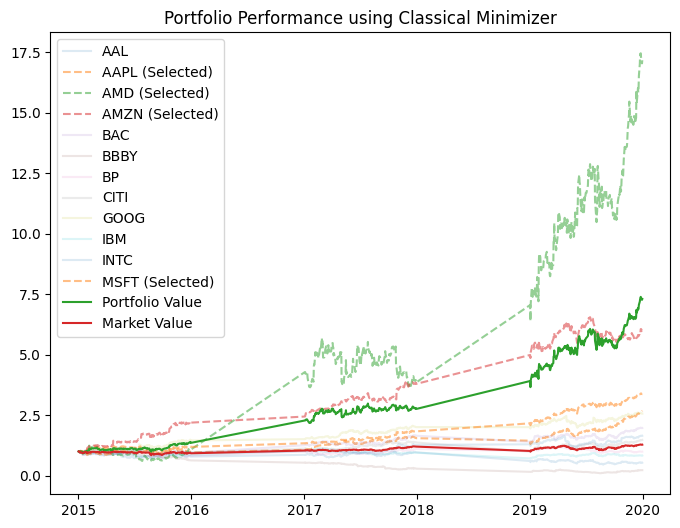

In [9]:
solve_classical(data_combined)

        Optimal Stock Combination: AMD AMZN BAC GOOG 
qubits 		 selection 	 value 		 probability
[0 0 1 1 1 0 0 0 1 0 0 0] AMD AMZN BAC GOOG  -0.0077 	 0.002
[0 1 1 1 1 0 0 0 0 0 0 0] AAPL AMD AMZN BAC  -0.0077 	 0.002
[0 0 1 1 0 0 0 1 0 0 1 0] AMD AMZN CITI INTC  -0.007 	 0.001
[0 0 1 1 1 0 0 1 0 0 0 0] AMD AMZN BAC CITI  -0.0069 	 0.0039
[0 1 1 0 1 0 0 0 1 0 0 0] AAPL AMD BAC GOOG  -0.0068 	 0.0029
------------------------------------------------------------ 



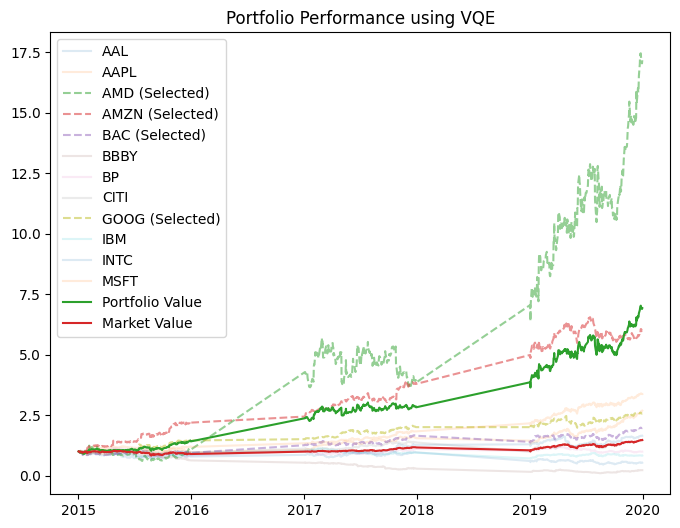

In [10]:
solve_vqe(data_combined)

        Optimal Stock Combination: AMD AMZN GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 1 1 0 0 0 0 1 0 0 1] AMD AMZN GOOG MSFT  -0.0085 	 0.001
[0 1 1 1 0 0 0 0 1 0 0 0] AAPL AMD AMZN GOOG  -0.0084 	 0.001
[0 0 1 1 0 0 0 0 0 0 1 1] AMD AMZN INTC MSFT  -0.0079 	 0.0029
[0 0 1 1 0 0 0 1 0 0 0 1] AMD AMZN CITI MSFT  -0.0078 	 0.001
[0 0 1 1 0 0 1 0 0 0 0 1] AMD AMZN BP MSFT  -0.0071 	 0.001
------------------------------------------------------------ 



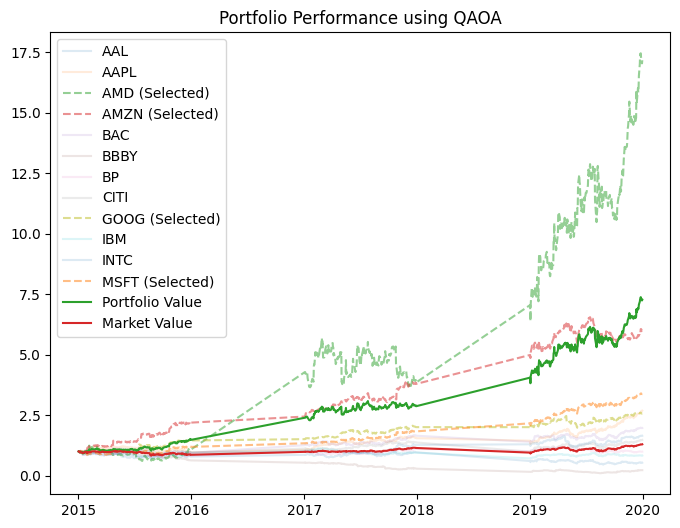

In [11]:
solve_qaoa(data_combined)

Combining the data from the years 2015, 2017, and 2019, the classical minimizer, VQE, and QAOA all recommend the portfolio: AAPL, AMD, AMZN, and MSFT. The results are probabilistic; in previous runs, we have observed different recommendations using VQE in particular.

1.B) Analyze the portfolio and compare to market when optimizing the portfolio for each year separately.

        Optimal Stock Combination: AMD AMZN GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 1 1 0 0 0 0 1 0 0 1] AMD AMZN GOOG MSFT  -0.0059 	 1.0
------------------------------------------------------------ 



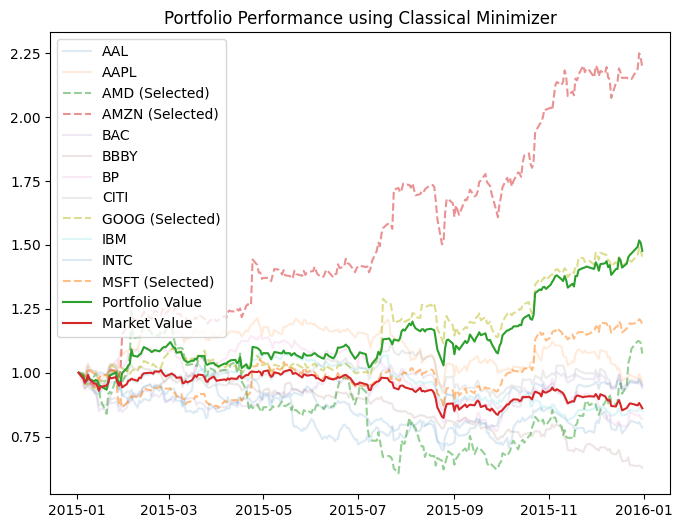

        Optimal Stock Combination: AAL AMD AMZN GOOG 
qubits 		 selection 	 value 		 probability
[1 0 1 1 0 0 0 0 1 0 0 0] AAL AMD AMZN GOOG  -0.0044 	 0.001
[0 1 0 1 0 0 0 0 1 0 1 0] AAPL AMZN GOOG INTC  -0.0043 	 0.001
[0 1 0 1 1 0 0 0 1 0 0 0] AAPL AMZN BAC GOOG  -0.0043 	 0.001
[0 0 0 1 1 0 0 1 1 0 0 0] AMZN BAC CITI GOOG  -0.0042 	 0.0068
[0 1 0 1 0 0 0 0 1 1 0 0] AAPL AMZN GOOG IBM  -0.0039 	 0.0049
------------------------------------------------------------ 



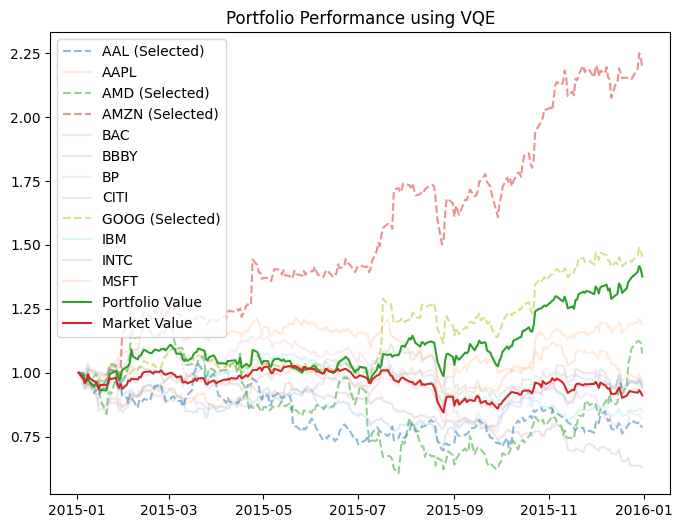

        Optimal Stock Combination: AMD AMZN GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 1 1 0 0 0 0 1 0 0 1] AMD AMZN GOOG MSFT  -0.0059 	 0.001
[0 0 1 1 0 0 0 0 1 0 1 0] AMD AMZN GOOG INTC  -0.005 	 0.001
[0 0 0 1 0 0 1 0 1 0 0 1] AMZN BP GOOG MSFT  -0.0046 	 0.001
[0 0 1 1 0 0 1 0 1 0 0 0] AMD AMZN BP GOOG  -0.0045 	 0.001
[1 0 1 1 0 0 0 0 1 0 0 0] AAL AMD AMZN GOOG  -0.0044 	 0.001
------------------------------------------------------------ 



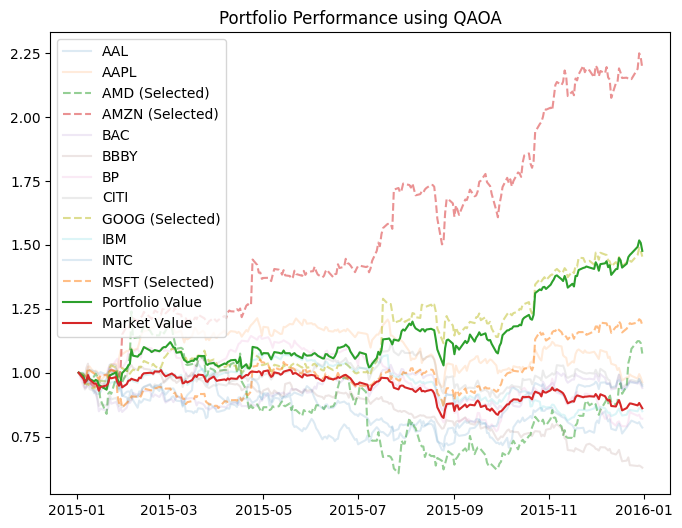

        Optimal Stock Combination: AAPL AMZN BAC MSFT 
qubits 		 selection 	 value 		 probability
[0 1 0 1 1 0 0 0 0 0 0 1] AAPL AMZN BAC MSFT  -0.0057 	 1.0
------------------------------------------------------------ 



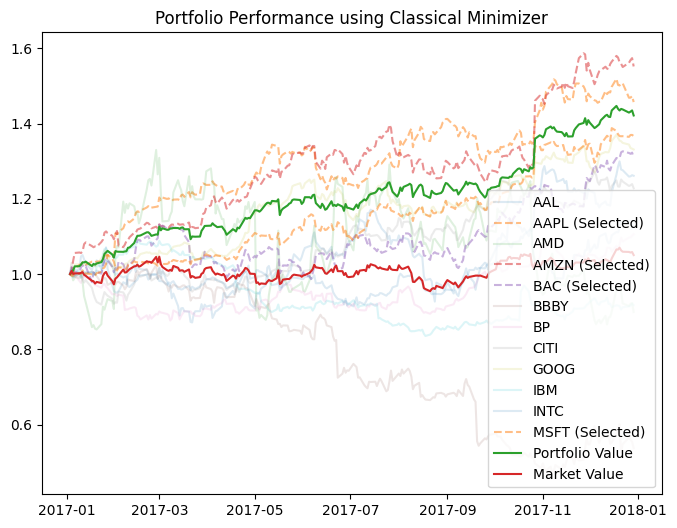

        Optimal Stock Combination: AMZN GOOG INTC MSFT 
qubits 		 selection 	 value 		 probability
[0 0 0 1 0 0 0 0 1 0 1 1] AMZN GOOG INTC MSFT  -0.0051 	 0.002
[0 1 0 0 1 0 0 0 1 0 0 1] AAPL BAC GOOG MSFT  -0.005 	 0.0029
[0 1 0 1 0 0 1 0 0 0 0 1] AAPL AMZN BP MSFT  -0.005 	 0.002
[0 0 0 1 0 0 0 1 1 0 1 0] AMZN CITI GOOG INTC  -0.0047 	 0.001
[0 1 0 0 1 0 0 1 1 0 0 0] AAPL BAC CITI GOOG  -0.0046 	 0.001
------------------------------------------------------------ 



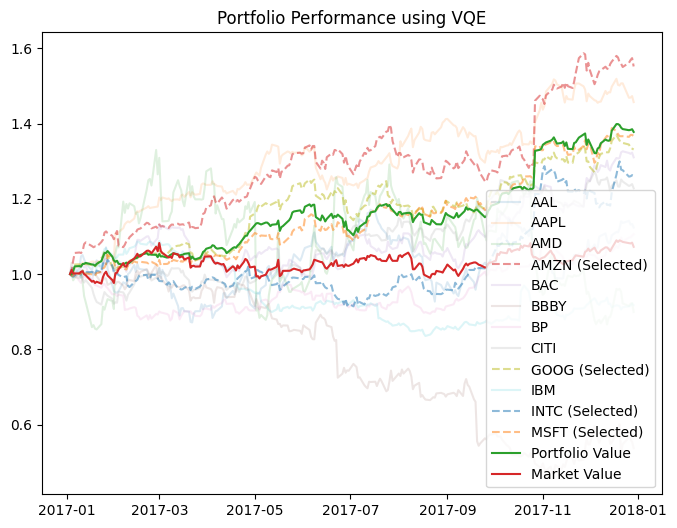

        Optimal Stock Combination: AAPL AMZN GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 1 0 1 0 0 0 0 1 0 0 1] AAPL AMZN GOOG MSFT  -0.0056 	 0.001
[0 1 0 1 1 0 0 0 0 0 1 0] AAPL AMZN BAC INTC  -0.0053 	 0.001
[0 1 0 1 0 0 0 0 1 0 1 0] AAPL AMZN GOOG INTC  -0.0053 	 0.001
[0 1 0 1 0 0 0 1 1 0 0 0] AAPL AMZN CITI GOOG  -0.0053 	 0.002
[1 1 0 1 0 0 0 0 0 0 0 1] AAL AAPL AMZN MSFT  -0.0051 	 0.0029
------------------------------------------------------------ 



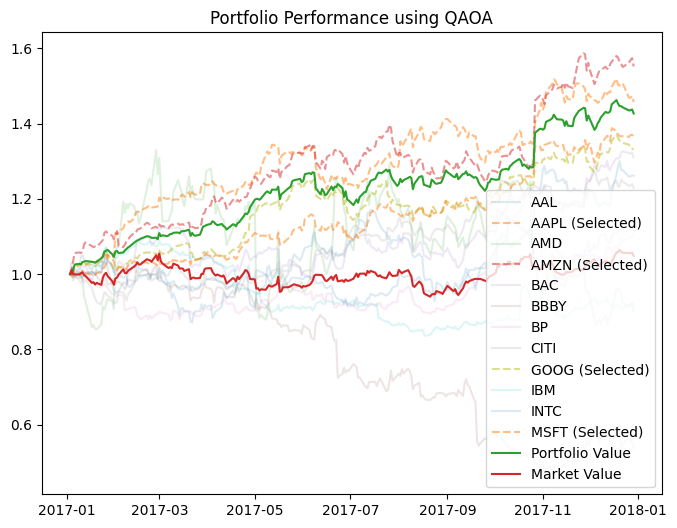

        Optimal Stock Combination: AAPL AMD BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 0 1] AAPL AMD BBBY MSFT  -0.0097 	 1.0
------------------------------------------------------------ 



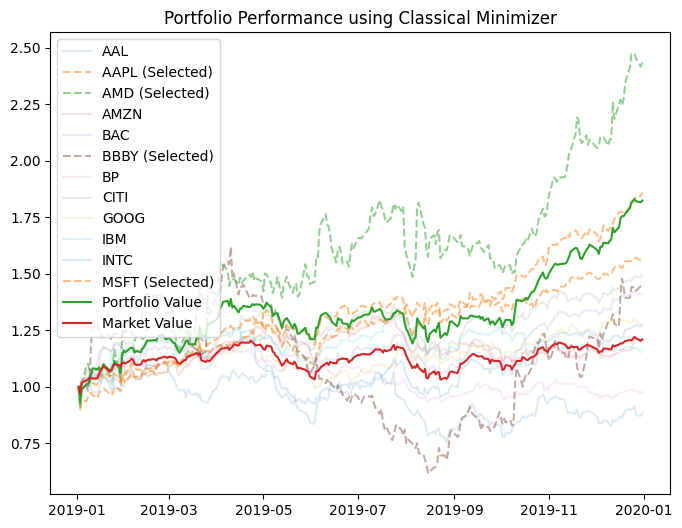

        Optimal Stock Combination: AMD BAC BBBY CITI 
qubits 		 selection 	 value 		 probability
[0 0 1 0 1 1 0 1 0 0 0 0] AMD BAC BBBY CITI  -0.0084 	 0.001
[0 0 1 0 0 1 0 0 1 0 0 1] AMD BBBY GOOG MSFT  -0.0083 	 0.001
[0 0 1 0 0 1 0 1 1 0 0 0] AMD BBBY CITI GOOG  -0.0081 	 0.0029
[0 0 1 0 0 1 0 1 0 0 1 0] AMD BBBY CITI INTC  -0.008 	 0.001
[0 0 1 0 0 0 0 1 1 0 0 1] AMD CITI GOOG MSFT  -0.008 	 0.001
------------------------------------------------------------ 



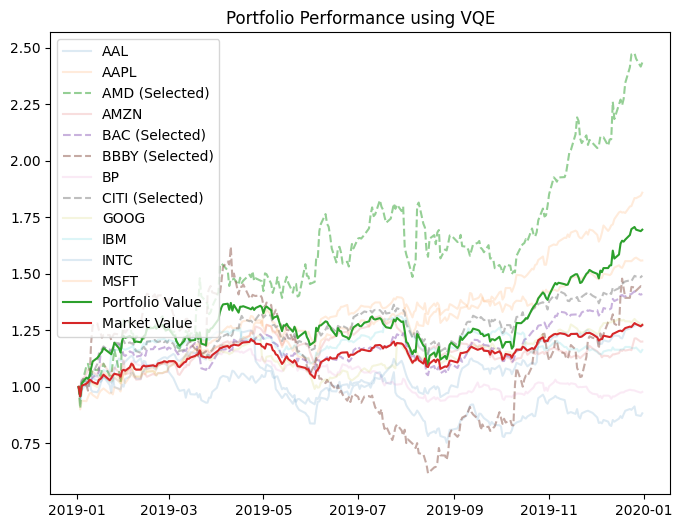

        Optimal Stock Combination: AAPL AMD BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 0 1] AAPL AMD BBBY MSFT  -0.0097 	 0.0039
[0 1 1 0 0 1 0 1 0 0 0 0] AAPL AMD BBBY CITI  -0.0095 	 0.002
[0 1 1 0 0 0 0 1 0 0 0 1] AAPL AMD CITI MSFT  -0.0095 	 0.002
[0 1 1 0 1 0 0 0 0 0 0 1] AAPL AMD BAC MSFT  -0.0093 	 0.001
[0 1 1 0 1 0 0 1 0 0 0 0] AAPL AMD BAC CITI  -0.0091 	 0.001
------------------------------------------------------------ 



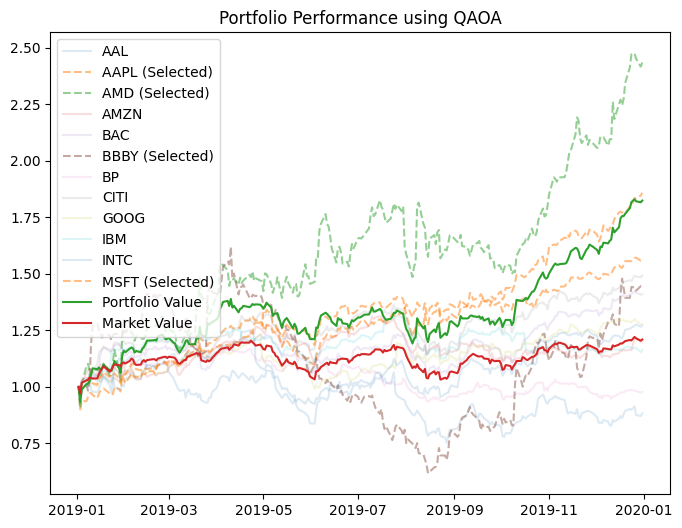

In [12]:
for data in [data_2015, data_2017, data_2019]:
  solve_classical(data)
  solve_vqe(data)
  solve_qaoa(data)

### Problem 2
For this study you may choose the same 12 stocks or random data for 12 datasets over 1 year.

2.A) Compare the outcome and convergence speed using VQE for 4 variational forms:

1. 2 sets of rotation and entanglement blocks using only parametrized Ry-gates for each qubit in each rotation block and CX-gates in linear arrangement (CX(qi,qj) for all j=i+1) for entanglement.
2. 4 sets of rotation and entanglement layers using only parametrized Ry-gates for each qubit in each rotation block and CX-gates in linear arrangement for entanglement.
3. 2 sets of rotation and entanglement layers using parametrized Ry-gates and Rz-gates for each qubit in each rotation block and CX-gates in full arrangement (CX(qi,qj) for all combination of i,j) for entanglement.
4. 4 sets of rotation and entanglement layers using parametrized Ry-gates ad Rz-gates for each qubit in each rotation block and CX-gates in full arrangement for entanglement.

        Optimal Stock Combination: AAPL AMD BAC BBBY 
qubits 		 selection 	 value 		 probability
[0 1 1 0 1 1 0 0 0 0 0 0] AAPL AMD BAC BBBY  -0.0093 	 0.0039
[0 1 1 0 1 0 0 1 0 0 0 0] AAPL AMD BAC CITI  -0.0091 	 0.002
[0 0 1 0 0 1 0 1 0 0 0 1] AMD BBBY CITI MSFT  -0.0088 	 0.002
[0 0 1 0 1 1 0 0 0 0 0 1] AMD BAC BBBY MSFT  -0.0086 	 0.001
[0 1 1 0 1 0 0 0 1 0 0 0] AAPL AMD BAC GOOG  -0.0085 	 0.002
------------------------------------------------------------ 



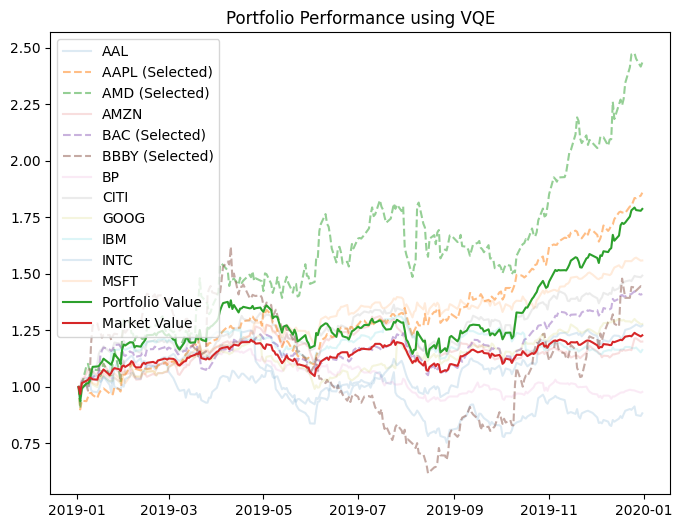

In [13]:
def linear_entanglement_ansatz(n_layers):
  n_qubits = len(stocks)

  qc = QuantumCircuit(n_qubits)

  theta = ParameterVector('theta', n_qubits * n_layers)

  for layer in range(n_layers):
    for i in range(n_qubits):
      qc.ry(theta[layer * n_qubits + i], i)
      qc.cx(i, (i + 1) % n_qubits)

  return qc

# Ansatz 1
solve_vqe(data_2019, linear_entanglement_ansatz(2))

        Optimal Stock Combination: AAPL AMD BBBY INTC 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 1 0] AAPL AMD BBBY INTC  -0.0089 	 0.0029
[0 1 1 0 1 0 0 0 1 0 0 0] AAPL AMD BAC GOOG  -0.0085 	 0.001
[0 1 1 0 0 0 0 0 0 1 1 0] AAPL AMD IBM INTC  -0.0077 	 0.001
[1 1 1 0 0 1 0 0 0 0 0 0] AAL AAPL AMD BBBY  -0.0075 	 0.001
[0 0 1 0 1 0 0 0 0 1 0 1] AMD BAC IBM MSFT  -0.0075 	 0.001
------------------------------------------------------------ 



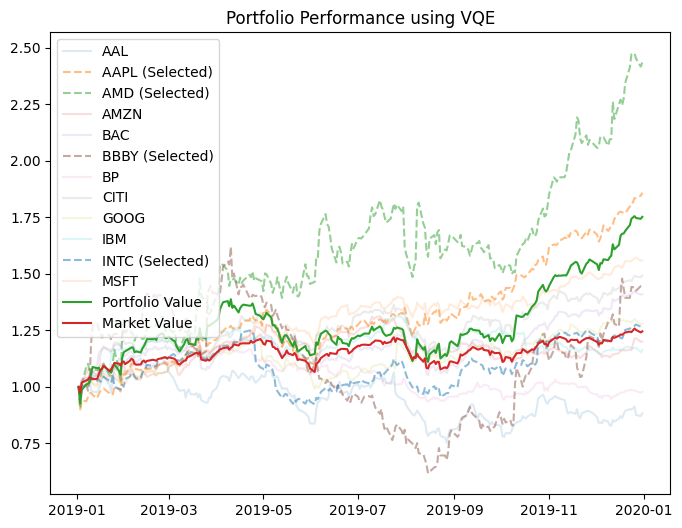

In [14]:
# Ansatz 2
solve_vqe(data_2019, linear_entanglement_ansatz(4))

        Optimal Stock Combination: AMD BAC BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 0 1 0 1 1 0 0 0 0 0 1] AMD BAC BBBY MSFT  -0.0086 	 0.001
[0 0 1 0 0 0 0 1 0 0 1 1] AMD CITI INTC MSFT  -0.008 	 0.001
[0 1 1 0 0 0 1 1 0 0 0 0] AAPL AMD BP CITI  -0.0077 	 0.001
[0 1 0 0 0 0 0 1 1 0 0 1] AAPL CITI GOOG MSFT  -0.0068 	 0.001
[0 1 0 0 0 1 0 1 0 0 1 0] AAPL BBBY CITI INTC  -0.0068 	 0.002
------------------------------------------------------------ 



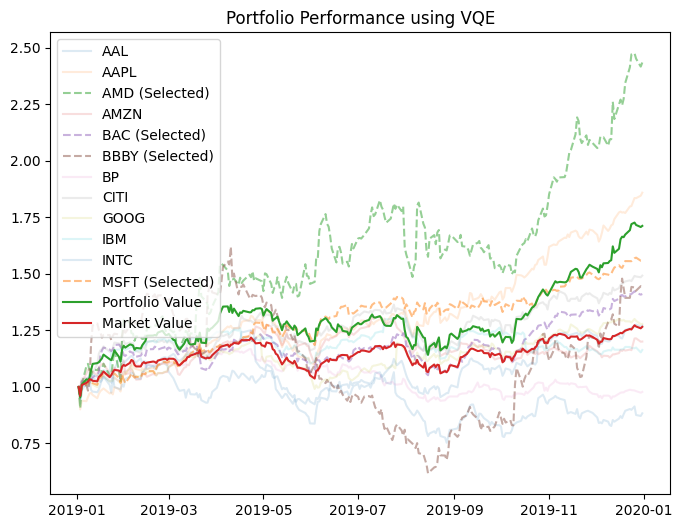

In [15]:
def full_entanglement_ansatz(n_layers):
  n_qubits = len(stocks)

  qc = QuantumCircuit(n_qubits)

  theta_y = ParameterVector('theta_y', n_qubits * n_layers)
  theta_z = ParameterVector('theta_z', n_qubits * n_layers)

  for layer in range(n_layers):
    for i in range(n_qubits):
      qc.ry(theta_y[layer * n_qubits + i], i)
      qc.rz(theta_z[layer * n_qubits + i], i)
      for j in range(n_qubits):
        qc.cx(i, j)

  return qc

# Ansatz 3
solve_vqe(data_2019, linear_entanglement_ansatz(2))

        Optimal Stock Combination: AAPL AMD BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 0 1] AAPL AMD BBBY MSFT  -0.0097 	 0.001
[0 1 1 0 0 0 0 0 1 0 0 1] AAPL AMD GOOG MSFT  -0.0089 	 0.002
[0 1 1 1 0 0 0 0 0 0 0 1] AAPL AMD AMZN MSFT  -0.0086 	 0.001
[0 1 1 0 0 0 0 0 1 0 1 0] AAPL AMD GOOG INTC  -0.0081 	 0.0029
[0 0 1 0 0 1 0 1 0 0 1 0] AMD BBBY CITI INTC  -0.008 	 0.001
------------------------------------------------------------ 



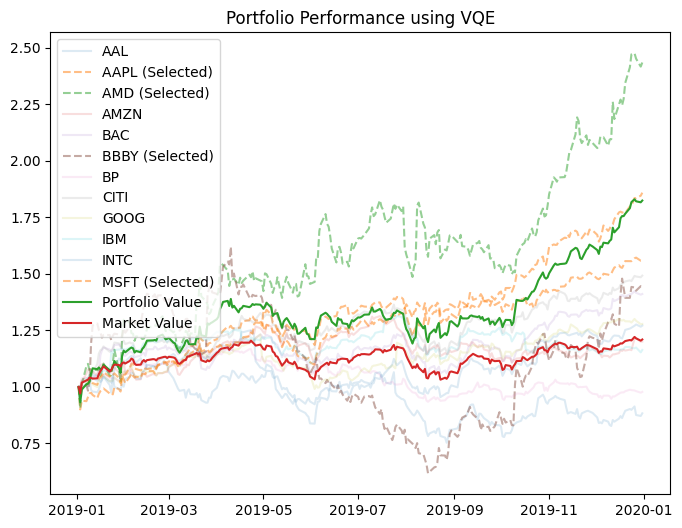

In [16]:
# Ansatz 4
solve_vqe(data_2019, linear_entanglement_ansatz(4))

2.B) Compare outcome and convergence speed of part 2.A with an optimization using QAOA with 2 and 4 layers.

The following two cells show that QAOA with 2 and 4 layers run in 6.6s and 6.7s respectively; in contrast, all of the VQE runs in part 2.A finish in under 3.6 seconds. This suggests that VQE converges faster. As for outcome, both QAOA runs recommend a portfolio consisting of AAPL, AMD, BBBY, and MSFT. Each of the VQE runs contains at least three of these in its recommendations, suggesting similar outcomes. 

        Optimal Stock Combination: AAPL AMD BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 0 1] AAPL AMD BBBY MSFT  -0.0097 	 0.002
[0 1 1 0 1 1 0 0 0 0 0 0] AAPL AMD BAC BBBY  -0.0093 	 0.001
[0 1 1 0 1 0 0 0 0 0 0 1] AAPL AMD BAC MSFT  -0.0093 	 0.001
[0 1 1 0 1 0 0 1 0 0 0 0] AAPL AMD BAC CITI  -0.0091 	 0.001
[0 1 1 0 0 1 0 0 1 0 0 0] AAPL AMD BBBY GOOG  -0.0089 	 0.0039
------------------------------------------------------------ 



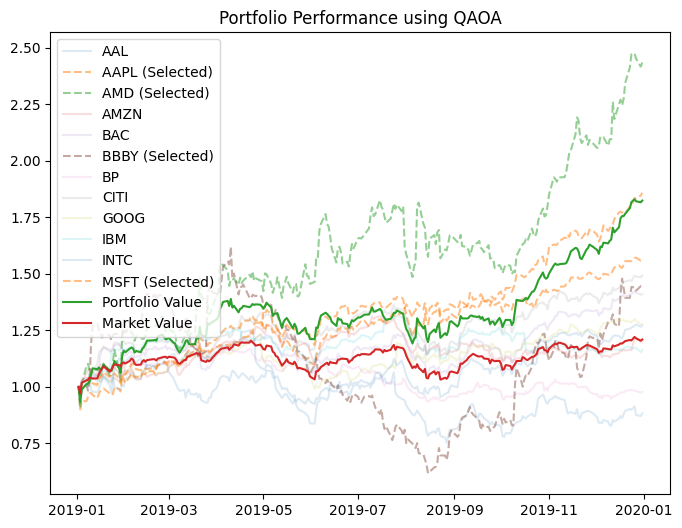

In [17]:
solve_qaoa(data_2019, layers=2)

        Optimal Stock Combination: AAPL AMD BBBY MSFT 
qubits 		 selection 	 value 		 probability
[0 1 1 0 0 1 0 0 0 0 0 1] AAPL AMD BBBY MSFT  -0.0097 	 0.001
[0 1 1 0 0 1 0 1 0 0 0 0] AAPL AMD BBBY CITI  -0.0095 	 0.001
[0 1 1 0 1 1 0 0 0 0 0 0] AAPL AMD BAC BBBY  -0.0093 	 0.001
[0 1 1 0 1 0 0 0 0 0 0 1] AAPL AMD BAC MSFT  -0.0093 	 0.001
[0 1 1 0 0 0 0 0 1 0 0 1] AAPL AMD GOOG MSFT  -0.0089 	 0.002
------------------------------------------------------------ 



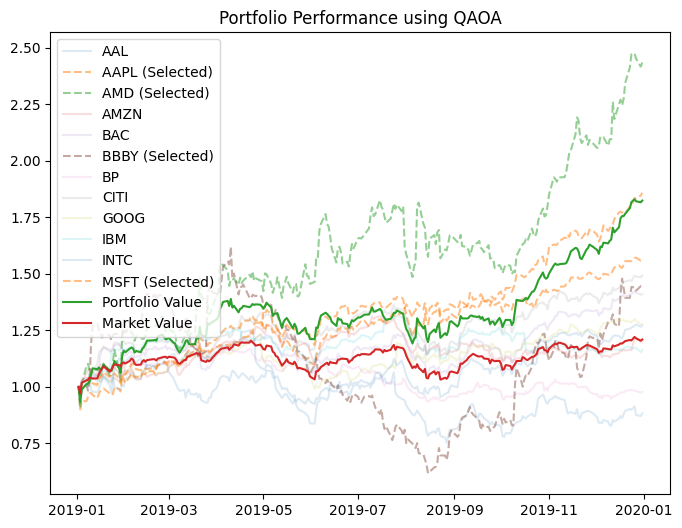

In [18]:
solve_qaoa(data_2019, layers=4)